In [92]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import custom_module as cm

In [93]:
# Loading the dataset
data = pd.read_csv("/Users/ahsan/Dropbox/My Mac (Alnoors-MBP-2.hub)/Downloads/combined_data.csv", parse_dates=True)

In [94]:
data["SETTLEMENTDATE"] = pd.to_datetime(data["SETTLEMENTDATE"])
data.index = data["SETTLEMENTDATE"]
data.drop(columns="SETTLEMENTDATE", inplace=True)

In [95]:
# The Real Test Data Set To Test Later #
X_test = data["2019-01-01":"2019-06-30"].copy()
X_test = X_test["RESIDUAL_DEMAND"]

In [61]:
# replace outliers by outlier threshold
#data = cm.replace_outliers(data, 'RRP5MIN', 5)

In [96]:
data

,RRP5MIN,RESIDUAL_DEMAND
SETTLEMENTDATE,,
2010-10-20 00:00:00,1.963450,1296.50
2010-10-20 00:05:00,1.955553,1275.46
2010-10-20 00:10:00,1.946951,1268.40
2010-10-20 00:15:00,1.953207,1267.73
2010-10-20 00:20:00,1.835252,1261.69
...,...,...
2019-06-30 23:40:00,5.998145,546.95
2019-06-30 23:45:00,5.961220,560.19
2019-06-30 23:50:00,5.066510,559.87


In [64]:
data.dropna(inplace=True)

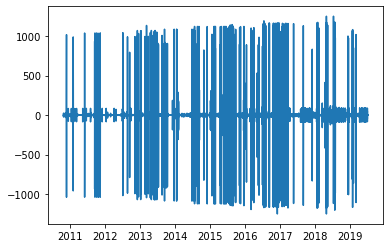

In [65]:
plt.plot(data["RRP5MIN"])

In [97]:
# Scaling the RRP between 0 and 1 as required by the NN
scaler = MinMaxScaler()
data["RESIDUAL_DEMAND"] = scaler.fit_transform(data["RESIDUAL_DEMAND"].values.reshape(-1,1))

In [98]:
data

,RRP5MIN,RESIDUAL_DEMAND
SETTLEMENTDATE,,
2010-10-20 00:00:00,1.963450,0.521335
2010-10-20 00:05:00,1.955553,0.516411
2010-10-20 00:10:00,1.946951,0.514758
2010-10-20 00:15:00,1.953207,0.514602
2010-10-20 00:20:00,1.835252,0.513188
...,...,...
2019-06-30 23:40:00,5.998145,0.345898
2019-06-30 23:45:00,5.961220,0.348997
2019-06-30 23:50:00,5.066510,0.348922


In [99]:
train = pd.DataFrame(data["RESIDUAL_DEMAND"].loc["2017":].copy())

In [100]:
# include time lags of timeseries data for 3 days = 864
# We will use 3 days data to identify patterns to predict the next day

lags = 864
for i in range(1,lags+1):
    train["l_{}".format(i)] = train["RESIDUAL_DEMAND"].shift(i)

In [101]:
# Drop NANS
train.dropna(inplace=True)
train.tail(5)

,RESIDUAL_DEMAND,l_1,l_2,l_3,l_4,l_5,l_6,l_7,l_8,l_9,...,l_855,l_856,l_857,l_858,l_859,l_860,l_861,l_862,l_863,l_864
SETTLEMENTDATE,,,,,,,,,,,,,,,,,,,,,
2019-06-30 23:40:00,0.345898,0.338296,0.311225,0.293039,0.292739,0.301238,0.299665,0.302191,0.306008,0.308522,...,0.208860,0.193441,0.199798,0.202709,0.201684,0.208247,0.215145,0.219831,0.223016,0.232273
2019-06-30 23:45:00,0.348997,0.345898,0.338296,0.311225,0.293039,0.292739,0.301238,0.299665,0.302191,0.306008,...,0.219379,0.208860,0.193441,0.199798,0.202709,0.201684,0.208247,0.215145,0.219831,0.223016
2019-06-30 23:50:00,0.348922,0.348997,0.345898,0.338296,0.311225,0.293039,0.292739,0.301238,0.299665,0.302191,...,0.214829,0.219379,0.208860,0.193441,0.199798,0.202709,0.201684,0.208247,0.215145,0.219831
2019-06-30 23:55:00,0.345926,0.348922,0.348997,0.345898,0.338296,0.311225,0.293039,0.292739,0.301238,0.299665,...,0.216163,0.214829,0.219379,0.208860,0.193441,0.199798,0.202709,0.201684,0.208247,0.215145
2019-07-01 00:00:00,0.351366,0.345926,0.348922,0.348997,0.345898,0.338296,0.311225,0.293039,0.292739,0.301238,...,0.209953,0.216163,0.214829,0.219379,0.208860,0.193441,0.199798,0.202709,0.201684,0.208247


In [103]:
# create feature and label dataframes
prelim_features = train.drop(['RESIDUAL_DEMAND'], axis=1)
prelim_labels = pd.DataFrame(train[['RESIDUAL_DEMAND']])


In [104]:
# format labels to 24 hour output range
for i in range(0, 288):
    prelim_labels['t_{}'.format(i)] = prelim_labels['RESIDUAL_DEMAND'].shift(-i)
prelim_labels.drop(['RESIDUAL_DEMAND'], axis=1, inplace=True)

# apply one-day discretization to the data
labels = prelim_labels[prelim_labels.index.minute == 0]
labels = labels[labels.index.hour == 0]
features = prelim_features[prelim_features.index.minute == 0]
features = features[features.index.hour == 0]

features_train = features[:'2018']
features_test = features['2019':'2019-06-30']
labels_train = labels[:'2018']

samples_train = len(features_train)
samples_test = len(features_test)
timesteps = 864

# convert pandas data frames to numpy ndarrays
features_train = features_train.to_numpy().reshape(samples_train, timesteps, 1)
features_test = features_test.to_numpy().reshape(samples_test, timesteps, 1)
labels_train = labels_train.to_numpy()

# check for correct data shape
features_train.shape, labels_train.shape

((727, 864, 1), (727, 288))

In [105]:
from keras.models import Model, load_model
from keras.layers.convolutional import Conv1D
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import json

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Input

In [106]:
# split into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(features_train, labels_train, test_size=0.2, random_state=7)

In [107]:
###################### DESIGNING THE NN ###################
##########################################################
## 1D Convolution layer to avoid overfitting
## 3 layers of LSTM considering the complexity of the dataset

# Initialising
rnn = Sequential()
# Adding Conv1D Layer
rnn.add(Conv1D(64, kernel_size=288, strides=288, padding='valid', input_shape=(X_train.shape[1],1)))
# Add LSTM layer 1st
rnn.add(LSTM(128, recurrent_activation='relu', return_sequences=True))
rnn.add(Dropout(0.1))
# Add LSTM layer 2nd
rnn.add(LSTM(64, recurrent_activation='relu'))
rnn.add(Dropout(0.1))
rnn.add(Dense(units=288))
rnn.compile(optimizer='adam', loss='mse')

In [108]:
# train the model and calculate the performance on the test set
results, hist = cm.train_predict_evaluate(rnn, X_train, X_valid, y_train, y_valid, features_test,
                                       X_test.to_numpy().flatten(), X_test.index, scaler, 32, 200, 
                                       'simple_neural_network.hdf5', verbose=1)

Epoch 1/200
19/19 [==============================] - 1s 48ms/step - loss: 0.1744 - val_loss: 0.1609
Epoch 2/200
19/19 [==============================] - 0s 22ms/step - loss: 0.1597 - val_loss: 0.1469
Epoch 3/200
19/19 [==============================] - 0s 21ms/step - loss: 0.1459 - val_loss: 0.1340
Epoch 4/200
19/19 [==============================] - 1s 29ms/step - loss: 0.1331 - val_loss: 0.1220
Epoch 5/200
19/19 [==============================] - 0s 24ms/step - loss: 0.1213 - val_loss: 0.1109
Epoch 6/200
19/19 [==============================] - 1s 28ms/step - loss: 0.1104 - val_loss: 0.1007
Epoch 7/200
19/19 [==============================] - 1s 43ms/step - loss: 0.1004 - val_loss: 0.0914
Epoch 8/200
19/19 [==============================] - 0s 24ms/step - loss: 0.0911 - val_loss: 0.0828
Epoch 9/200
19/19 [==============================] - 0s 25ms/step - loss: 0.0827 - val_loss: 0.0750
Epoch 10/200
19/19 [==============================] - 1s 27ms/step - loss: 0.0750 - val_loss: 0.0679

19/19 [==============================] - 0s 21ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 83/200
19/19 [==============================] - 0s 19ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 84/200
19/19 [==============================] - 0s 21ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 85/200
19/19 [==============================] - 0s 23ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 86/200
19/19 [==============================] - 0s 20ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 87/200
19/19 [==============================] - 0s 25ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 88/200
19/19 [==============================] - 0s 17ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 89/200
19/19 [==============================] - 0s 16ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 90/200
19/19 [==============================] - 0s 19ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 91/200
19/19 [==============================] - 0s 21ms/step - loss: 0.0121 - val_loss: 0.0125
Epo

19/19 [==============================] - 0s 22ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 163/200
19/19 [==============================] - 0s 17ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 164/200
19/19 [==============================] - 0s 17ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 165/200
19/19 [==============================] - 0s 16ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 166/200
19/19 [==============================] - 0s 16ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 167/200
19/19 [==============================] - 0s 18ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 168/200
19/19 [==============================] - 0s 20ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 169/200
19/19 [==============================] - 0s 23ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 170/200
19/19 [==============================] - 0s 19ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 171/200
19/19 [==============================] - 0s 21ms/step - loss: 0.0121 - val_loss: 0

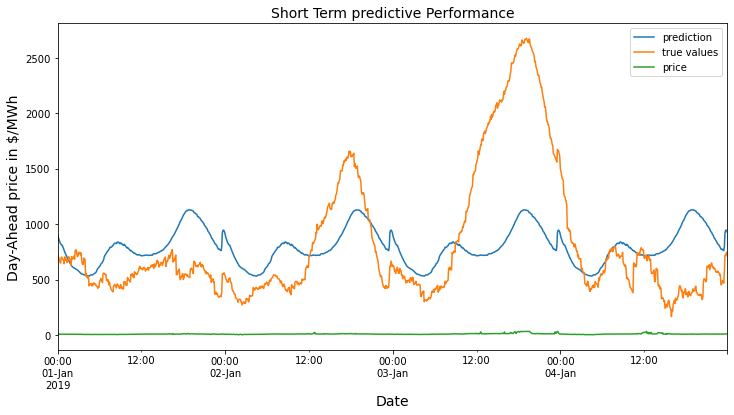

In [111]:
results["price"] = data["RRP5MIN"].loc['2019':'2019-06-30']
f, ax = plt.subplots(figsize=(12, 6))
results.loc['2019-01-01':'2019-01-04'].plot(ax=ax);
ax.set_ylabel('Day-Ahead price in $/MWh', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_title('Short Term predictive Performance', fontsize=14);

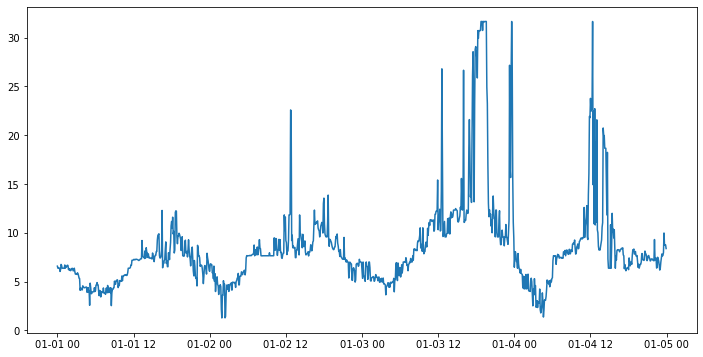

In [113]:
f, ax = plt.subplots(figsize=(12, 6))
plt.plot(results["price"].loc['2019-01-01':'2019-01-04'])

In [119]:
[x for x["RRP5MIN"] in (data["RRP5MIN"].loc['2019-01-01':'2019-01-04'] > 20)]

NameError: name 'x' is not defined

In [ ]:
cm.quantify_performance(results)

In [82]:
#model.compile(loss='mae', optimizer='adam')
checkpoint = ModelCheckpoint('./models/multidim_timeseries_testing.hdf5', save_best_only=True)

hist = rnn.fit(X_train, y_train,
                 validation_data=(X_valid, y_valid),
                 callbacks=[checkpoint], 
                 verbose=1, batch_size=50, epochs=250)

Epoch 1/250
12/12 [==============================] - 1s 54ms/step - loss: 0.2448 - val_loss: 0.2384
Epoch 2/250
12/12 [==============================] - 0s 24ms/step - loss: 0.2331 - val_loss: 0.2269
Epoch 3/250
12/12 [==============================] - 0s 32ms/step - loss: 0.2218 - val_loss: 0.2157
Epoch 4/250
12/12 [==============================] - 0s 26ms/step - loss: 0.2108 - val_loss: 0.2050
Epoch 5/250
12/12 [==============================] - 0s 29ms/step - loss: 0.2003 - val_loss: 0.1947
Epoch 6/250
12/12 [==============================] - 0s 38ms/step - loss: 0.1901 - val_loss: 0.1848
Epoch 7/250
12/12 [==============================] - 0s 33ms/step - loss: 0.1804 - val_loss: 0.1752
Epoch 8/250
12/12 [==============================] - 0s 33ms/step - loss: 0.1710 - val_loss: 0.1661
Epoch 9/250
12/12 [==============================] - 0s 31ms/step - loss: 0.1620 - val_loss: 0.1573
Epoch 10/250
12/12 [==============================] - 0s 22ms/step - loss: 0.1534 - val_loss: 0.1489

Epoch 79/250
12/12 [==============================] - 0s 28ms/step - loss: 4.1281e-04 - val_loss: 4.7839e-04
Epoch 80/250
12/12 [==============================] - 0s 23ms/step - loss: 3.6970e-04 - val_loss: 3.9627e-04
Epoch 81/250
12/12 [==============================] - 0s 25ms/step - loss: 3.8556e-04 - val_loss: 4.7048e-04
Epoch 82/250
12/12 [==============================] - 0s 22ms/step - loss: 3.9580e-04 - val_loss: 2.7981e-04
Epoch 83/250
12/12 [==============================] - 0s 20ms/step - loss: 4.1500e-04 - val_loss: 3.0356e-04
Epoch 84/250
12/12 [==============================] - 0s 25ms/step - loss: 3.8686e-04 - val_loss: 4.9447e-04
Epoch 85/250
12/12 [==============================] - 0s 30ms/step - loss: 3.7589e-04 - val_loss: 3.0856e-04
Epoch 86/250
12/12 [==============================] - 0s 21ms/step - loss: 3.9320e-04 - val_loss: 3.7823e-04
Epoch 87/250
12/12 [==============================] - 0s 23ms/step - loss: 4.0406e-04 - val_loss: 3.4687e-04
Epoch 88/250
12/12 

12/12 [==============================] - 0s 19ms/step - loss: 2.3893e-04 - val_loss: 2.4809e-04
Epoch 228/250
12/12 [==============================] - 0s 20ms/step - loss: 2.2564e-04 - val_loss: 2.1847e-04
Epoch 229/250
12/12 [==============================] - 0s 21ms/step - loss: 2.4162e-04 - val_loss: 2.8805e-04
Epoch 230/250
12/12 [==============================] - 0s 22ms/step - loss: 2.3523e-04 - val_loss: 2.2564e-04
Epoch 231/250
12/12 [==============================] - 0s 19ms/step - loss: 2.5228e-04 - val_loss: 2.3518e-04
Epoch 232/250
12/12 [==============================] - 0s 25ms/step - loss: 2.3808e-04 - val_loss: 2.2897e-04
Epoch 233/250
12/12 [==============================] - 0s 21ms/step - loss: 2.3546e-04 - val_loss: 2.1768e-04
Epoch 234/250
12/12 [==============================] - 0s 20ms/step - loss: 2.3591e-04 - val_loss: 2.3509e-04
Epoch 235/250
12/12 [==============================] - 0s 24ms/step - loss: 2.3179e-04 - val_loss: 2.7068e-04
Epoch 236/250
12/12 [===

In [83]:
best = load_model('./models/multidim_timeseries_testing.hdf5')
# pred = best.predict([input_test, input_test[:, :, 3]])
pred = best.predict(features_test)
#pred = scaler.inverse_transform(pred.flatten().reshape(-1, 1))

In [85]:
pred = scaler.inverse_transform(pred.flatten().reshape(-1, 1))

In [88]:
plot(pred)

NameError: name 'plot' is not defined